# Surrogate Construction for Genz Functions with regression as a function of the number of training points

This notebook constructs a PC surrogate for Genz functions using random sampling and regression, giving the RMS error bewteen the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [1]:
# imports
import numpy as np
import math  
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *
import PyUQTk.uqtkarray as uqtkarray

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


## Inputs

In [2]:
nord = 6         # Order of the PCE
pc_type = "LU"     # Polynomial type
pc_alpha = 0.0     # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
nSam = 10000       # Number of evaluation samples samples
max_dim=6         # Maximum number of dimensions to include
model= 'genz_ppeak'  # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

First, we define the random number generator.

## Collecting Errors

We loop through different numbers of random samples to feed into regression and obtain the RMSE. We start with a number of samples equal to 90% of the basis terms and continue to 125%.

In [3]:
sigma = np.array([1.e-08]) # inital noise variance; updated in BCS
eta = 1e-7                 # threshold for stopping the algorithm
lambda_init = np.array([]) # set lambda to a fixed nonnegative value

scale = 0.1     # diagonal loading parameter
adaptive = 1    # generative basis for adaptive CS, 0 or 1
optimal = 1     # use the rigorous implementation of adaptive CS, 0 or 1

In [4]:
percent=[.6, .7, .8, .9, 1, 1.10, 1.2, 1.3, 1.4, 1.5, 1.9, 2] # fractions of the number of basis terms to use

# arrays to store error statistics for each dimension
mean_dim_errors=np.zeros((max_dim, len(percent)))
std_dim_errors=np.zeros((max_dim, len(percent)))

terms=np.zeros((max_dim, len(percent)))
nonz=[]

# loop through each dimension
for ndim in range(1, max_dim+1):
    print("ndim", ndim)
    # instantiate random generator
    rng = qmc.LatinHypercube(d=ndim, seed=42)
    
    # instantiate PC object
    pc_model = uqtkpce.PCSet("NISPnoq", nord, ndim,pc_type, pc_alpha,pc_beta)
    npce=pc_model.GetNumberPCTerms()
    terms[ndim-1]=npce
    
    # list to store stats for each percent
    mean_per_errors=[]
    std_per_errors=[]

    for per in percent:
        nTest=int(npce*per)
    
        # list to store stats for the 10 trials
        RMSE_list=[]
        
        for i in range(10):
            # train PC at random samples
            
            coef=np.array([i+1 for i in range(pc_model.GetNumberPCTerms())])
            rand=2*rng.random(n=nTest)-1
            
            f_evals=pce_tools.UQTkEvaluatePCE(pc_model, coef, rand)
            
            # find coefficients
            c_k = pce_tools.UQTkBCS(pc_model, f_evals, rand, sigma, eta, lambda_init, adaptive, optimal, scale)
            
            # evaluate at random samples
            germ_samples=2*rng.random(n=nSam)-1
            pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,germ_samples)
         
            # find error
            f_actual=pce_tools.UQTkEvaluatePCE(pc_model, coef, germ_samples)
            MSE = np.square(np.subtract(f_actual,pce_evals)).mean()
            RMSE=math.sqrt(MSE)
            RMSE_list.append(RMSE)
            
            
        # add the results of the 10 trials    
        mean_per_errors.append(np.array(RMSE_list).mean())
        std_per_errors.append(np.std(np.array(RMSE_list)))
        
    nonz.append(len(np.nonzero(c_k)[0]))

    mean_dim_errors[ndim-1]=mean_per_errors
    std_dim_errors[ndim-1]=std_per_errors

ndim 1
ndim 2
ndim 3
ndim 4
ndim 5
ndim 6


## Summary
This table and figure display the error of each number of training points for each dimension. The number of training points varies as a percentage of the number of basis terms.

In [5]:
row_label=["dim "+str(i) for i in range(1, max_dim+1)]
pd.DataFrame(data=mean_dim_errors, index=row_label, columns=percent)

,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.9,2.0
dim 1,3.905245,3.970592,3.839346,3.067402,0.000004,0.000002,4.815496e-07,4.392069e-07,3.404331e-07,1.233422e-07,2.410864e-08,1.540028e-08
dim 2,23.015479,23.706310,17.034257,11.951646,0.042994,0.000256,2.014701e-06,6.713106e-06,2.639336e-06,6.015400e-07,1.875939e-07,3.595127e-06
dim 3,107.245311,102.078400,95.366573,63.881125,5.620582,2.726075,1.568906e-06,2.234268e-07,1.293289e-07,8.379215e-08,2.373892e-08,1.600083e-08
dim 4,366.359712,379.935589,326.521576,269.379652,49.285203,17.606720,1.228384e-07,5.342221e-08,2.320113e-08,1.838702e+00,6.994651e-09,4.695563e-09
dim 5,1005.032702,963.708514,848.661371,669.595591,302.144561,46.997276,8.235690e+01,3.291364e+01,7.050084e+01,2.115816e+00,4.463127e+01,6.741936e+01
dim 6,2815.405300,2292.560133,1965.472405,1471.332981,1002.001560,675.911260,1.723554e+02,1.573629e+02,2.093742e+02,1.732149e+02,1.033239e+02,4.463199e+01


In [6]:
pd.DataFrame(data=terms, index=row_label, columns=percent)
np.transpose(terms)[0]

array([  7.,  28.,  84., 210., 462., 924.])

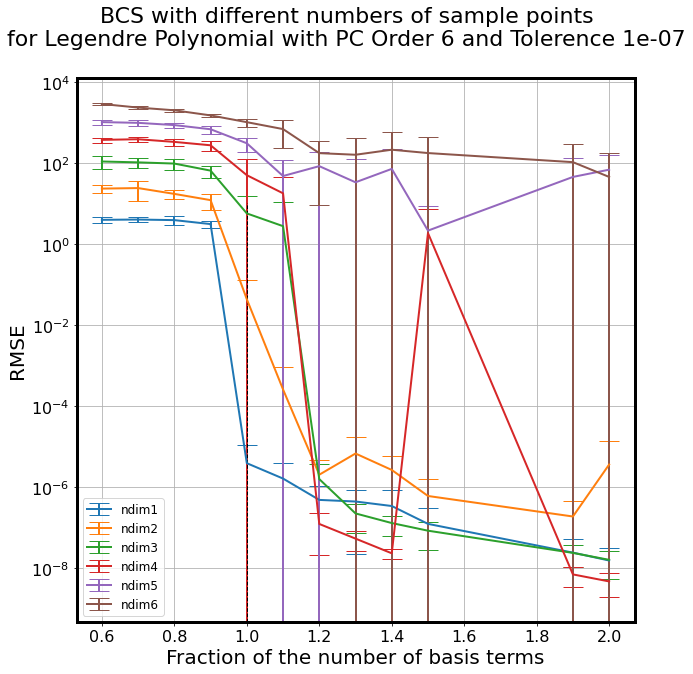

In [7]:
# Create figure
fig, ax = plt.subplots(figsize=(10,10))

# Plot Error Data
for ndim in range(1, max_dim +1):
    plt.errorbar(percent, mean_dim_errors[ndim-1], yerr=std_dim_errors[ndim-1], xerr=None, linewidth=2, markersize=8, capsize=10, label=str('ndim'+str(ndim)))

# Line where number of samples = number of basis terms
plt.vlines(x = 1, ymin = 0, ymax = 10, colors = 'black', linestyle="dashed")

# Label Axes
plt.xlabel("Fraction of the number of basis terms",fontsize=20)
plt.ylabel("RMSE",fontsize=20)

# Create legend
plt.legend(loc='lower left')

# Model titles to be displayed
if model=="genz_osc":
    model_title="Genz Oscillatory"
elif model=="genz_gaus":
    model_title="Genz Gaussian"
elif model=="genz_ppeak":
    model_title="Genz Product-Peak"
elif model=="genz_cpeak":
    model_title="Genz Corner-Peak"
elif model=="genz_exp":
    model_title="Genz Exponential"
else:
    model_title="Genz Continuous"

# Add title
fig.suptitle("BCS with different numbers of sample points\nfor Legendre Polynomial with\
 PC Order %s and Tolerence %s"%(str(nord), str(eta)), fontsize=22)

# Change y scale
plt.yscale('log')

#Change size of tick labels
plt.tick_params(axis='both', labelsize=16)

#Show figure
plt.show() 